[*********************100%***********************]  1 of 1 completed


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.04840413014810657
                Count_Open  Count_High  Count_Low  Count_Close  Count_Sum
Price_Level($)                                                           
21.0                  38.0        50.0       34.0         40.0      162.0
20.0                  39.0        26.0       39.0         36.0      140.0
22.0                  20.0        25.0       10.0         18.0       73.0
46.0                  14.0        18.0       14.0          9.0       55.0
44.0                  11.0        16.0       12.0         13.0       52.0
...                    ...         ...        ...          ...        ...
102.0                  0.0         0.0        0.0          1.0        1.0
101.0                  0.0         0.0        1.0          0.0        1.0
88.0                   1.0         0.0        0.0          0.0        1.0
62.0                   0.0         0.0        0.0          1.0        1.0
160.0                  0.0         1.0        0.0          0.0        1.0

[137 rows x 5 col

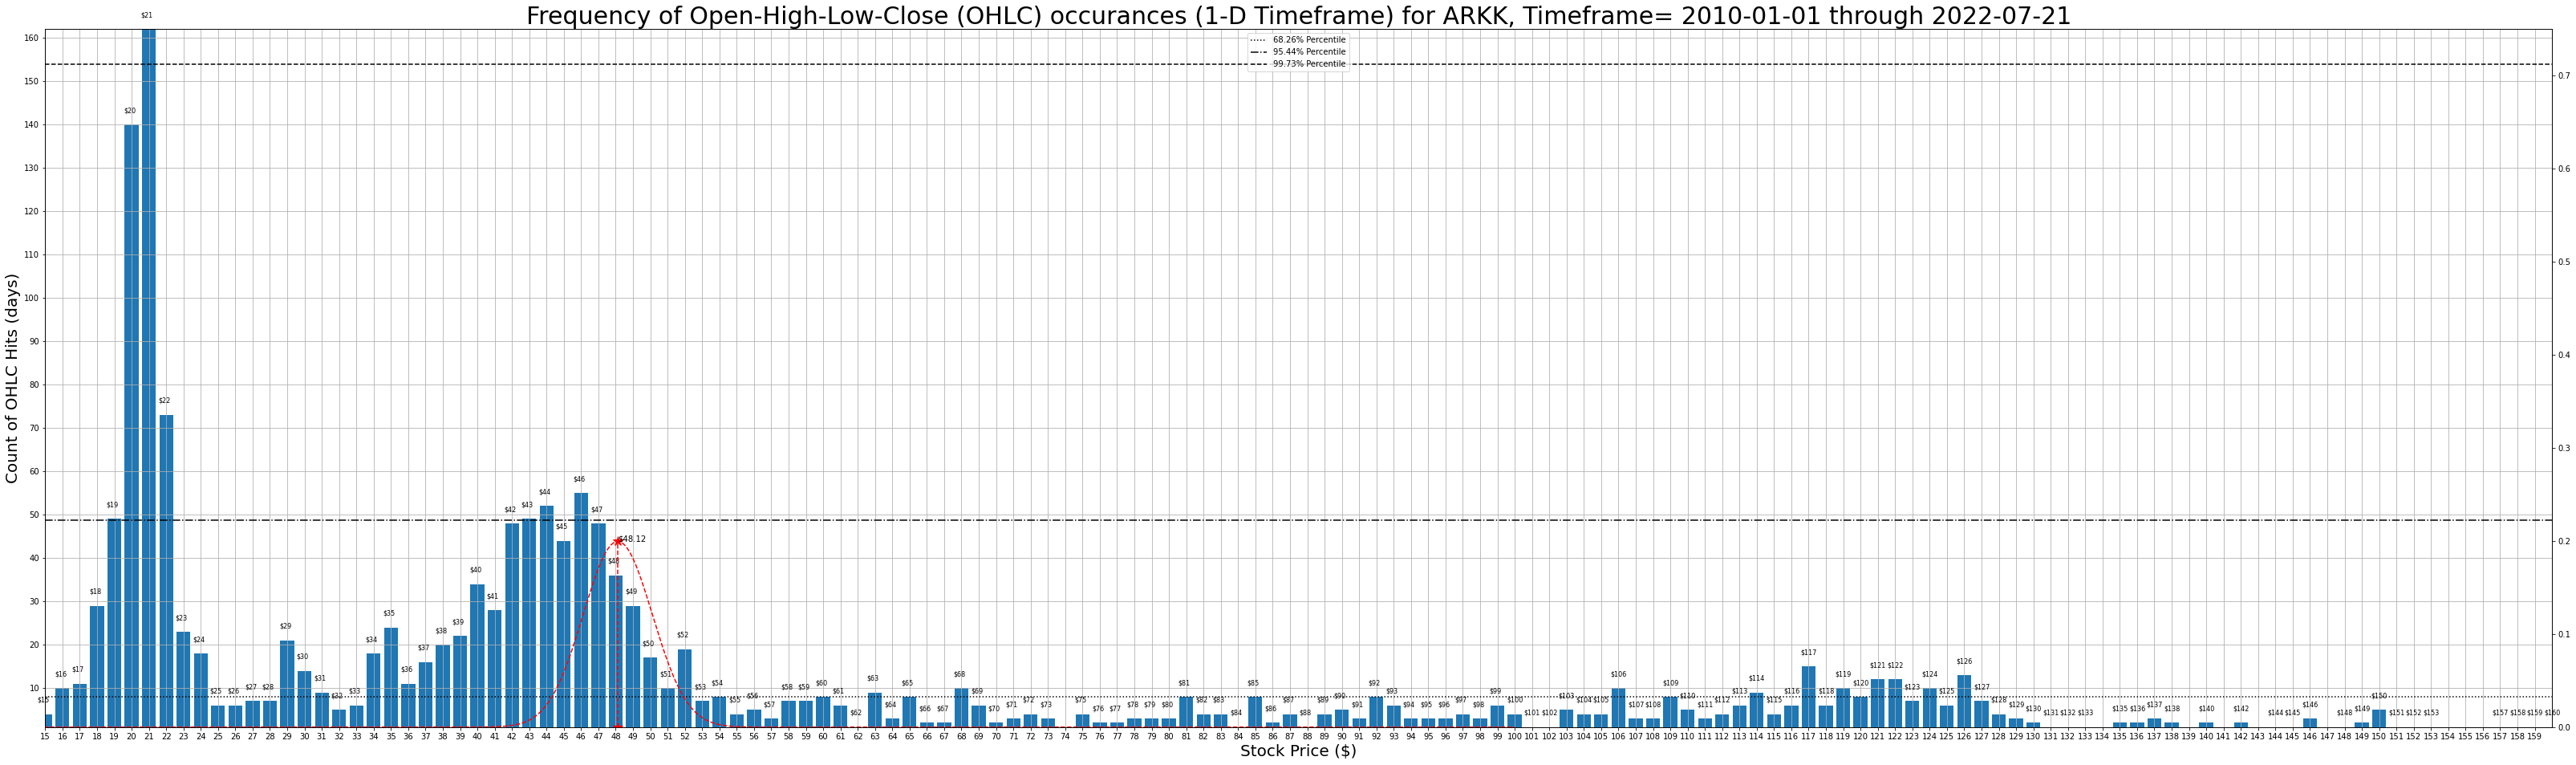

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date
import math

def GetStockData(ticker,start_date,end_date,interval):
    df = yf.download(ticker, start_date, end_date,interval=interval).dropna()
    return(df)

def Round(df,base):
    df = base*round(df/base)
    return(df)

def Last_Price(df):
    Last_Price=df.Close[len(df.Close)-1]
    return(Last_Price)

def Get_STD(df):
    df['log_R'] = np.log(df.Close) - np.log(df.Close.shift(1))
    STD=np.std(df.log_R)
    return(STD)
               
def GroupOHLC(df):
    df['Date']=df.index
    
    #Group by individual OHLC columns
    dfo=pd.DataFrame(df.groupby('Open').count().sort_values(by='Date',ascending=False).Date)
    dfh=pd.DataFrame(df.groupby('High').count().sort_values(by='Date',ascending=False).Date)
    dfl=pd.DataFrame(df.groupby('Low').count().sort_values(by='Date',ascending=False).Date)
    dfc=pd.DataFrame(df.groupby('Close').count().sort_values(by='Date',ascending=False).Date)
    
    #Join OHLC columns
    df=dfo.join(dfh,how='outer',rsuffix='o',sort=True)
    df=df.join(dfl,how='outer',rsuffix='h',sort=True)
    df=df.join(dfc,how='outer',rsuffix='l',sort=True).fillna(0)
    
    #Sum and name OHLC columns
    df['total']=df.sum(axis=1)
    df.columns=['Count_Open','Count_High','Count_Low','Count_Close','Count_Sum']
    df=df.sort_values(by='Count_Sum',ascending=False)
    df.index.name='Price_Level($)'
    return(df)

def PlotData(df,Last_Price,ticker,start_date,end_date):
    #Plot Stem-plot
    fig, ax = plt.subplots()
    #Set X and Y
    X=df.index
    Y=df.Count_Sum
    ax.bar(X,Y)

    #Add Grid
    ax.grid()
    #Resize
    fig.set_size_inches(56, 16)
    #Add X-ticks
    ax.xaxis.set_ticks(np.arange(np.min(X),np.max(X),1))
    #Add Y-ticks
    ax.yaxis.set_ticks(np.arange(0,np.max(Y),10))
    #Set X-label
    ax.set_xlabel('Stock Price ($)',size=20)
    #Set Y-label
    ax.set_ylabel('Count of OHLC Hits (days)',size=20)
    #Set Title
    ax.set_title('Frequency of Open-High-Low-Close (OHLC) occurances (1-D Timeframe) for '+ticker+', Timeframe= '+str(start_date)+' through '+str(end_date),size=30)
    
    
    #Add data labels
    for x,y in zip(X,Y):
        label = "${:.0f}".format(x)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(-10,15), # distance from text to points (x,y)
                     fontsize=8,
                     ha='left') # horizontal alignment can be left, right or center
    
    #Limit Axes
    ax.set_xlim(np.min(X),np.max(X))
    ax.set_ylim(np.min(Y),np.max(Y))
    #Add Percentile Lines
    Sigma_1=np.percentile(df.Count_Sum,68.26)
    Sigma_2=np.percentile(df.Count_Sum,95.44)
    Sigma_3=np.percentile(df.Count_Sum,99.73)
    
    
    ax.plot([np.min(df.index),np.max(df.index)],[Sigma_1,Sigma_1],':k',label='68.26% Percentile')
    ax.plot([np.min(df.index),np.max(df.index)],[Sigma_2,Sigma_2],'-.k',label='95.44% Percentile')
    ax.plot([np.min(df.index),np.max(df.index)],[Sigma_3,Sigma_3],'--k',label='99.73% Percentile')

    
    leg = plt.legend(loc='upper center')
    return(fig, ax)

def AddNormalDist(fig, ax):    
    # Plot Normal Distribuation
    ax1=ax.twinx()
    mu=Last_Price
    std=2
    snd=stats.norm(mu,std)
    # Random variable X having different values
    x = np.linspace(0, 100, 1000)
    # Plotting different normal distribution curves simultaneously
    ax1.plot(x,snd.pdf(x),
            '--r')
    
    ax1.set_ylim(0,0.75)
   

    #Add Last Price
    ax1.plot([Last_Price,Last_Price],[0,0.2],
            '--*r',
            markersize=12,
            label=ticker+' Last Price (ref.)='+str("${:.2f}".format(Last_Price)))
    
    plt.annotate("${:.2f}".format(Last_Price),
                 (Last_Price,0.2))
    return(ax.plot)
    
ticker="ARKK"

start_date="2010-01-01"
end_date=date.today()
interval="1wk"    
base=1

df=GetStockData(ticker,start_date,end_date,interval)
Last_Price=Last_Price(df)
STD=Get_STD(df)

df=Round(df,base)
df=GroupOHLC(df)
df.to_csv('Price_Level_Significance_'+ticker+'_'+str(start_date)+'_'+str(end_date)+'.csv')
fig, ax = PlotData(df,Last_Price,ticker,start_date,end_date)
AddNormalDist(fig, ax)
print(STD)

print(df)